# **Importing essential libraries**

In [ ]:
!pip install transformers
!pip install -U datasets
!pip install soundfile
!pip install librosa
!pip install gradio
!pip install torch

In [ ]:
# Install FastAPI and Uvicorn
!pip install fastapi uvicorn python-multipart

# Install pyngrok to expose the Colab server
!pip install pyngrok

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering
from datasets import load_dataset , load_from_disk

# **NLP**

Natural Language Processing (NLP) is a field of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language. In simpler terms, it's about teaching computers to communicate with us in the way we naturally speak and write.

Think of it like this:

* **Understanding:** When you ask your smart speaker a question, NLP helps it figure out what you're saying.
* **Interpreting:** If you search for "best restaurants," NLP helps the search engine understand that you're looking for places to eat.
* **Generating:** When your phone suggests the next word as you type, or when a chatbot responds to your query, that's NLP generating language.

**Why is NLP important?**

Because human language is incredibly complex! Words can have multiple meanings, sentences can be structured in countless ways, and context is crucial. NLP tries to bridge the gap between how humans communicate and how computers process information.

### How Transformer Architecture Reshaped NLP

For a long time, NLP models struggled with understanding the long-range dependencies in language – how a word at the beginning of a sentence might relate to a word much later. They also found it difficult to process words in parallel, often having to go through a sentence word by word.

Then came the **Transformer architecture**, introduced in the 2017 paper "Attention Is All You Need." It was a game-changer because it addressed these limitations in a very clever way.

Here's a simplified breakdown of how Transformers reshaped NLP:

1.  **Parallel Processing (Speed Boost):**
    * **Before Transformers:** Many NLP models (like Recurrent Neural Networks - RNNs) processed words sequentially, one after another. Imagine reading a book word by word and only understanding the next word after you've read the previous one. This was slow, especially for long sentences.
    * **With Transformers:** Transformers can process all words in a sentence *simultaneously*. It's like being able to quickly glance at all the words in a paragraph at once and understand the overall meaning. This parallel processing capability drastically speeds up training and inference.

2.  **"Attention" Mechanism (Understanding Context Better):**
    * **The Problem:** In long sentences, traditional models often "forgot" information from the beginning of the sentence by the time they reached the end.
    * **The Transformer's Solution:** The core innovation of Transformers is the "self-attention mechanism." This allows the model to weigh the importance of different words in the input sentence when processing a particular word.
        * **Analogy:** Imagine you're reading the sentence "The cat, which was black, sat on the mat." When the Transformer processes the word "sat," it doesn't just look at "on the mat." It "pays attention" to "cat" and realizes that "sat" is the action performed by the "cat." It can even pay attention to "black" to understand the cat's description.
        * This mechanism helps the model understand the relationships between all words in a sentence, regardless of their distance, making it much better at grasping context and meaning.

3.  **No More Recurrence (Simpler and More Robust):**
    * Traditional RNNs relied on "recurrence," meaning they fed their output back into themselves. This could lead to issues like vanishing or exploding gradients, making them hard to train effectively for very long sequences.
    * Transformers entirely removed this recurrence. This made them more stable and easier to train on massive datasets.

**Impact on NLP:**

The Transformer architecture has led to monumental advancements in NLP, enabling:

* **Much more accurate machine translation:** Google Translate and other services became significantly better.
* **Sophisticated chatbots and virtual assistants:** They can understand and respond more naturally.
* **Powerful text summarization:** Models can now generate concise summaries of long documents.
* **Amazing text generation:** Models like GPT-3 and its successors can write coherent and creative text, code, and even poetry.
* **Improved sentiment analysis:** Better understanding of the emotion behind text.

# **Making API**

In [ ]:
from google.colab import userdata
NG_Token = userdata.get('NGROK_Token')

In [ ]:
!ngrok config add-authtoken NG_Token

In [ ]:
%%writefile app.py
# app.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer, AutoModelForCausalLM
import uvicorn
import os
from pyngrok import ngrok # Import pyngrok for tunneling
from contextlib import asynccontextmanager # For FastAPI's lifespan events
import asyncio # For async operations within lifespan
import sys # Import sys for exiting if there's a critical config error
from typing import List, Dict, Union
import torch # Import torch to check for CUDA availability

# --- Application Configuration ---
APP_PORT = 8000 # The port your FastAPI app will run on locally
QA_MODEL_NAME = "deepset/roberta-base-squad2"
GEN_MODEL_NAME = "openai-community/gpt2" # Changed to GPT-2

# If you have a ngrok reserved domain (e.g., 'your-subdomain.ngrok-free.app'), set it here.
# Otherwise, leave it as None to get a random free ngrok URL.
RESERVED_NGROK_DOMAIN = None

# --- Global Variables for Models ---
# These will be initialized within the lifespan function for proper startup/shutdown
qa_pipeline = None
gen_tokenizer = None # Will store the tokenizer directly
gen_model = None     # Will store the model directly
device = 0 if torch.cuda.is_available() else -1 # Determine device once globally

# --- Model Loading Function ---
async def load_models():
    """
    Loads both the QA model (with pipeline) and Text Generation model (directly) into global variables.
    """
    global qa_pipeline, gen_tokenizer, gen_model, device

    print(f"Loading QA model: {QA_MODEL_NAME}...")
    try:
        qa_model_obj = AutoModelForQuestionAnswering.from_pretrained(QA_MODEL_NAME)
        qa_tokenizer_obj = AutoTokenizer.from_pretrained(QA_MODEL_NAME)
        qa_pipeline = pipeline('question-answering', model=qa_model_obj, tokenizer=qa_tokenizer_obj, device=device)
        print(f"QA Model '{QA_MODEL_NAME}' loaded successfully on device: {'CUDA GPU' if device == 0 else 'CPU'}")
    except Exception as e:
        print(f"ERROR: Failed to load QA model '{QA_MODEL_NAME}': {e}")
        sys.exit(1) # Critical error, exit application

    print(f"Loading Text Generation model directly: {GEN_MODEL_NAME}...")
    try:
        gen_tokenizer = AutoTokenizer.from_pretrained(GEN_MODEL_NAME)
        gen_model = AutoModelForCausalLM.from_pretrained(GEN_MODEL_NAME)

        # GPT-2 doesn't have a specific chat template like Llama or DeepSeek.
        # For direct generation, it's good practice to set a pad_token_id if it doesn't have one,
        # often to the eos_token_id, especially if batching inputs.
        if gen_tokenizer.pad_token is None:
            gen_tokenizer.pad_token = gen_tokenizer.eos_token
            print(f"Set tokenizer.pad_token to tokenizer.eos_token for {GEN_MODEL_NAME}.")

        if device == 0:
            gen_model.to("cuda")
            print(f"Text Generation Model '{GEN_MODEL_NAME}' moved to GPU.")
        else:
            print(f"GPU not available, Text Generation Model '{GEN_MODEL_NAME}' running on CPU.")

        print(f"Text Generation Model '{GEN_MODEL_NAME}' and tokenizer loaded successfully on device: {'CUDA GPU' if device == 0 else 'CPU'}")
    except Exception as e:
        print(f"ERROR: Failed to load Text Generation model '{GEN_MODEL_NAME}': {e}")
        print("Please ensure you have sufficient RAM/VRAM and correct model files.")
        sys.exit(1) # Critical error, exit application


# --- ngrok Integration (Lifespan Events) ---
@asynccontextmanager
async def lifespan(app: FastAPI):
    """
    Handles startup and shutdown events for the FastAPI application.
    Loads both models and starts the ngrok tunnel on startup, tears it down on shutdown.
    """
    print("Application startup initiated...")

    # Load both models asynchronously
    await load_models()

    # Get ngrok auth token from the environment variable (managed by the external script)
    current_ngrok_auth_token = os.getenv("NGROK_AUTH_TOKEN")

    # Ensure ngrok auth token is set to proceed with tunneling
    if current_ngrok_auth_token:
        try:
            ngrok.set_auth_token(current_ngrok_auth_token)
            # Kill any existing ngrok tunnels from this session to avoid conflicts
            ngrok.kill()
            await asyncio.sleep(1) # Give it a moment for previous processes to fully terminate
            print("ngrok client killed (attempted previous tunnels, if any).")

            # Connect ngrok tunnel to the application port
            if RESERVED_NGROK_DOMAIN:
                tunnel = ngrok.connect(addr=APP_PORT, domain=RESERVED_NGROK_DOMAIN)
                public_url = tunnel.public_url
                print(f"FastAPI app exposed at **reserved domain**: {public_url}")
            else:
                tunnel = ngrok.connect(APP_PORT)
                public_url = tunnel.public_url
                print(f"FastAPI app exposed at **random free domain**: {public_url}")

        except Exception as e:
            print(f"ERROR: Failed to start ngrok tunnel: {e}")
            print("Please ensure your ngrok token is valid and, if using a reserved domain, that it's correctly configured in your ngrok dashboard.")
            print("ngrok tunnel will NOT be available.")
    else:
        print("WARNING: NGROK_AUTH_TOKEN environment variable not set. ngrok tunnel will NOT be created.")
        print("The FastAPI app will only be accessible locally (e.g., from other cells in this notebook).")

    yield # This allows the FastAPI application to run and serve requests

    # This code runs when the application is shutting down
    print("Application shutdown initiated...")
    try:
        if ngrok.get_tunnels(): # Check if there are active tunnels before disconnecting
            ngrok.disconnect()
            print("ngrok tunnel disconnected.")
        ngrok.kill() # Kill the ngrok agent process
        print("ngrok agent killed.")
    except Exception as e:
        print(f"Error during ngrok shutdown: {e}")

# Initialize FastAPI app with the lifespan manager
app = FastAPI(lifespan=lifespan)

# --- Pydantic Models for API Request/Response ---

# Pydantic Model for Question Answering API
class QAInput(BaseModel):
    question: str = Field(..., description="The question to be answered.")
    context: str = Field(..., description="The context text in which to find the answer.")

# Pydantic Models for Text Generation API
class Message(BaseModel):
    role: str = Field(..., description="Role of the message sender (e.g., 'user', 'assistant').")
    content: str = Field(..., description="Content of the message.")

class GenerateRequest(BaseModel):
    messages: List[Message] = Field(
        ...,
        min_items=1,
        description="A list of message objects, following the chat format. Example: [{'role': 'user', 'content': 'Who are you?'}]"
    )
    max_new_tokens: int = Field(100, ge=1, description="The maximum number of new tokens to generate.")
    do_sample: bool = Field(True, description="Whether to use sampling or greedy decoding.")
    temperature: float = Field(0.7, ge=0.1, le=2.0, description="The temperature to use for sampling.")
    top_k: int = Field(50, ge=1, description="The number of highest probability vocabulary tokens to keep for top-k filtering.")
    top_p: float = Field(1.0, ge=0.0, le=1.0, description="The cumulative probability for top-p filtering.")
    repetition_penalty: float = Field(1.0, ge=1.0, description="The parameter for repetition penalty. 1.0 means no penalty.")

class GenerateResponse(BaseModel):
    generated_text: str = Field(..., description="The generated text from the model.")

# --- FastAPI Endpoints ---

@app.get("/")
async def read_root():
    return {"message": "Welcome to the Combined NLP API! Visit /docs for OpenAPI documentation."}

## Question Answering Endpoint
@app.post("/qa/", response_model=Dict[str, Union[str, float, int]]) # Added int for start/end
async def get_answer(qa_input: QAInput):
    """
    Performs question answering on the provided context using the QA model.
    """
    if qa_pipeline is None:
        raise HTTPException(status_code=503, detail="Question Answering model not loaded yet. Please try again in a moment.")

    try:
        res = qa_pipeline(question=qa_input.question, context=qa_input.context)
        return {
            "question": qa_input.question,
            "context": qa_input.context,
            "answer": res['answer'],
            "score": res['score'],
            "start": res['start'],
            "end": res['end']
        }
    except Exception as e:
        print(f"Error in QA endpoint: {e}")
        raise HTTPException(status_code=500, detail=f"Failed to process QA request: {str(e)}")

## Text Generation Endpoint
@app.post("/generate/", response_model=GenerateResponse)
async def generate_text(request: GenerateRequest):
    """
    Generates text based on a list of chat messages using the GPT-2 model directly.
    """
    global gen_tokenizer, gen_model, device

    if gen_tokenizer is None or gen_model is None:
        raise HTTPException(status_code=503, detail="Text Generation model or tokenizer not loaded yet. Please try again in a moment.")

    try:
        # GPT-2 typically does not use chat templates like Llama or DeepSeek.
        # It expects a single string input. We'll concatenate messages for it.
        # For a simple text generation model, often the last user message is the prompt.
        # Or, you can concatenate all messages into a single prompt string.
        # For simplicity, let's take the content of the last message as the prompt.
        # You might need more sophisticated prompt engineering for better results with GPT-2.

        # Example: Simple concatenation of messages, role ignored
        # input_text = "\n".join([msg.content for msg in request.messages])

        # Example: Using the last user message as the direct prompt
        input_text = ""
        if request.messages:
            # Find the last message and use its content.
            # If you want to simulate a chat, you might prepend roles.
            # For GPT-2, a simple continuous text is often sufficient.
            input_text = request.messages[-1].content
        else:
            raise HTTPException(status_code=400, detail="No messages provided for text generation.")

        # Tokenize the input text
        # Move inputs to the correct device (GPU if available)
        inputs = gen_tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(gen_model.device)

        # Generate text
        # Use torch.no_grad() for inference to save memory and speed up computation
        with torch.no_grad():
            outputs = gen_model.generate(
                **inputs,
                max_new_tokens=request.max_new_tokens,
                do_sample=request.do_sample,
                temperature=request.temperature,
                top_k=request.top_k,
                top_p=request.top_p,
                repetition_penalty=request.repetition_penalty,
                pad_token_id=gen_tokenizer.pad_token_id or gen_tokenizer.eos_token_id, # Use pad_token_id, fall back to eos_token_id
                eos_token_id=gen_tokenizer.eos_token_id, # Explicitly set EOS token ID
            )

        # Decode the generated tokens.
        # We slice outputs[0] to exclude the input tokens and get only the new generation.
        # The number of input tokens is inputs.input_ids.shape[-1].
        generated_token_ids = outputs[0][inputs.input_ids.shape[-1]:]
        generated_text = gen_tokenizer.decode(generated_token_ids, skip_special_tokens=True)

        # Further cleanup: GPT-2 might generate trailing spaces or partial sentences
        generated_text = generated_text.strip()

        return GenerateResponse(generated_text=generated_text)

    except Exception as e:
        print(f"Error during text generation: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for detailed error analysis
        raise HTTPException(status_code=500, detail=f"Failed to generate text: {str(e)}")

# --- Application Entry Point ---
if __name__ == "__main__":
    # Uvicorn will run on the port defined by APP_PORT
    # It's crucial to bind to "0.0.0.0" so it's accessible externally (e.g., by ngrok).
    print(f"Starting Uvicorn server on host=0.0.0.0, port={APP_PORT}")
    uvicorn.run(app, host="0.0.0.0", port=APP_PORT, reload=False)

In [ ]:
# Run this in a separate cell after creating app.py
from pyngrok import ngrok
import nest_asyncio
import os # Import os

# Apply nest_asyncio to allow asyncio to be re-entered (needed for Colab and uvicorn)
nest_asyncio.apply()

# --- Ngrok Setup in the Notebook Cell ---
# Authenticate ngrok (replace with your actual auth token)
# You can get a free auth token from https://ngrok.com/signup
# Note: It's generally safer to store tokens in Colab secrets or environment variables
# rather than directly in the code, but for demonstration, we put it here.
NGROK_TOKEN = NG_Token # <--- REPLACE WITH YOUR ACTUAL NGROK AUTH TOKEN if different

# Set the ngrok auth token as an environment variable that app.py will read
os.environ["NGROK_AUTH_TOKEN"] = NGROK_TOKEN
print("NGROK_AUTH_TOKEN environment variable set.")

# You can optionally set the reserved domain here as well,
# or leave it to be picked up from the app.py config.
# os.environ["RESERVED_NGROK_DOMAIN"] = "your-subdomain.ngrok-free.app"


# --- Run the FastAPI app using Uvicorn ---
# !python app.py will execute the app.py script.
# The lifespan function inside app.py will read the NGROK_AUTH_TOKEN environment variable
# we just set and start the ngrok tunnel.
print(f"Starting app.py (Uvicorn server)...")

# Running the script with !python will block the cell.
# The ngrok public URL will be printed by the app.py script's lifespan function.
# You might need to stop the cell (Runtime -> Interrupt execution) to proceed
# or open a new Colab tab to interact with the API via the public_url printed by app.py.
!python app.py

# **Huggingface Pipelines**

## **Question-Answering**

In [ ]:
model_name = "deepset/roberta-base-squad2"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

# Provide a context that contains the answer
QA_input = {
    'question': 'what is the capital city of pakistan?',
    'context': "Islamabad is the capital city of Pakistan."
}
res = nlp(QA_input)

# b) Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(res)

## **question-answering**

In [ ]:
# question-answering
question_answerer = pipeline('question-answering')
question_answerer(
    question = 'Where do I work?',
    context = 'My name is Farhan and I work as Machine LErning Engineer in Pakistan.'
)

## **Sentiment-Analysis**

In [ ]:
classifier = pipeline('sentiment-analysis')  # We can specify model
classifier('I am very happy')

In [ ]:
classifier = pipeline('sentiment-analysis')  # We can specify model
classifier(['I am very happy', "I'm very sad"])

## **zero-shot-classification**

In [ ]:
zero_shot_classifier = pipeline("zero-shot-classification")
zero_shot_classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

## **Text-generation**

In [ ]:
text_generator = pipeline("text-generation")
text = text_generator("In this course, we will teach you ")

In [ ]:
# Get the raw generated text
generated_text = text[0]['generated_text']
print(generated_text)

In [ ]:
text_generator = pipeline("text-generation", model = 'distilgpt2')
text = text_generator("In this course, we will teach you ", max_length=30, num_return_sequences=2)
print(text)

In [ ]:
text_generator = pipeline("text-generation", model='distilgpt2')

# Corrected call with more precise hyperparameters
text = text_generator(
    "In this course, we will teach you ",
    max_new_tokens=30,  # Generate a maximum of 30 *new* tokens after the prompt
    num_return_sequences=2,
    do_sample=True,     # Enable sampling for more diverse (less repetitive) output
    temperature=0.7,    # Control randomness: lower for more focused, higher for more creative
    top_k=50,           # Sample from the top 50 most likely tokens
    # top_p=0.9,        # Alternatively, sample from tokens whose cumulative probability is 0.9
    repetition_penalty=1.2 # Penalize repeated tokens to reduce redundancy
)
print(text)

## **fill-mask**

In [ ]:
fill_mask = pipeline('fill-mask')
fill_mask(f'HuggingFace is creating a {fill_mask.tokenizer.mask_token} that the community uses to solve NLP tasks.')

In [ ]:
fill_mask = pipeline('fill-mask')
fill_mask("HuggingFace is creating a <mask> that the community uses to solve NLP tasks.", top_k = 2)

## **entity-recognition**

In [ ]:
# named entity pipline
ner = pipeline('ner', grouped_entities=True)
ner("My name is Farhan and I work at Hugging Face in US.")

## **summarization**

In [ ]:
# summarization
summary = pipeline('summarization')
summary('''
The Balfour Declaration was a public statement issued by the British Government in 1917 during the First World War announcing its support for the establishment of a "national home for the Jewish people"
in Palestine, then an Ottoman region with a small minority Jewish population. The declaration was contained in a letter dated 2 November 1917 from Arthur Balfour, the British foreign secretary, to Lord Rothschild,
a leader of the British Jewish community, for transmission to the Zionist Federation of Great Britain and Ireland. The text of the declaration was published in the press on 9 November 1917. Following Britain's declaration
of war on the Ottoman Empire in November 1914, it began to consider the future of Palestine. Within two months a memorandum was circulated to the War Cabinet by a Zionist member, Herbert Samuel, proposing the support of
Zionist ambitions to enlist the support of Jews in the wider war. A committee was established in April 1915 by British prime minister H. H. Asquith to determine their policy towards the Ottoman Empire including Palestine.
Asquith, who had favoured post-war reform of the Ottoman Empire, resigned in December 1916; his replacement David Lloyd George favoured partition of the Empire. The first negotiations between the British and the Zionists
took place at a conference on 7 February 1917 that included Sir Mark Sykes and the Zionist leadership. Subsequent discussions led to Balfour's request, on 19 June, that Rothschild and Chaim Weizmann draft a public declaration.
Further drafts were discussed by the British Cabinet during September and October, with input from Zionist and anti-Zionist Jews but with no representation from the local population in Palestine.
By late 1917, the wider war had reached a stalemate, with two of Britain's allies not fully engaged: the United States had yet to suffer a casualty, and the Russians were in the midst of a revolution.
A stalemate in southern Palestine was broken by the Battle of Beersheba on 31 October 1917. The release of the final declaration was authorised on 31 October; the preceding Cabinet discussion had referenced perceived
propaganda benefits amongst the worldwide Jewish community for the Allied war effort. The opening words of the declaration represented the first public expression of support for Zionism by a major political power.
The term "national home" had no precedent in international law, and was intentionally vague as to whether a Jewish state was contemplated. The intended boundaries of Palestine were not specified, and the British government
later confirmed that the words "in Palestine" meant that the Jewish national home was not intended to cover all of Palestine. The second half of the declaration was added to satisfy opponents of the policy,
who had claimed that it would otherwise prejudice the position of the local population of Palestine and encourage antisemitism worldwide by "stamping the Jews as strangers in their native lands".
The declaration called for safeguarding the civil and religious rights for the Palestinian Arabs, who composed the vast majority of the local population, and also the rights and political status
of the Jewish communities in countries outside of Palestine. The British government acknowledged in 1939 that the local population's wishes and interests should have been taken into account,
and recognised in 2017 that the declaration should have called for the protection of the Palestinian Arabs' political rights. The declaration greatly increased popular support for Zionism within
Jewish communities worldwide, and became a core component of the British Mandate for Palestine, the founding document of Mandatory Palestine.
It indirectly led to the emergence of the State of Israel and is considered a principal cause of the ongoing Israeli–Palestinian conflict – often described as the most intractable in the world.
Controversy remains over a number of areas, such as whether the declaration contradicted earlier promises the British made to the Sharif of Mecca in the McMahon–Hussein correspondence.
''')

## **translation**

In [ ]:
# translation
translation = pipeline('translation', model = "Helsinki-NLP/opus-mt-fr-en")
translation("Ce cours est produit par Hugging Face.")

## **image-classification**

In [ ]:
image_classifier = pipeline(
    task="image-classification", model="google/vit-base-patch16-224"
)
result = image_classifier(
    "/content/download.jpg"
)
print(result)

## **automatic-speech-recognition**

In [ ]:
transcriber = pipeline(
    task="automatic-speech-recognition", model="openai/whisper-large-v3"
)
result = transcriber(
    "https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/mlk.flac"
)
print(result)

# **Behind the pipeline**
**Tokenization** is the process of breaking down raw text (like a sentence or paragraph) into smaller, meaningful units called **tokens**.

Think of it as slicing a continuous piece of text into individual "words" or "parts of words" that a computer can understand and process.

Here's why it's essential for Large Language Models (LLMs):

1.  **Numerical Representation:** LLMs work with numbers, not directly with text. Tokenization converts text into a sequence of numerical IDs that the model can then look up in an embedding table to get meaningful numerical representations.
2.  **Vocabulary Management:** It helps manage the vastness of human language by mapping words (or parts of words) to a fixed vocabulary.
3.  **Handling Out-of-Vocabulary (OOV) Words:** Many tokenizers (especially subword tokenizers) can break down unknown words into smaller, known subword units, allowing the model to still process them even if the full word wasn't in its training vocabulary.

**Example:**

Input Sentence: "Hugging Face is great!"

**Possible Tokenization:**

* **Word-level:** \["Hugging", "Face", "is", "great", "!"\]
* **Subword-level (common for LLMs):** \["Hug", "##ging", "Face", "is", "great", "!"\] (The `##` indicates it's part of a previous word)

Each of these tokens then gets converted into a numerical ID that the LLM uses for its computations.

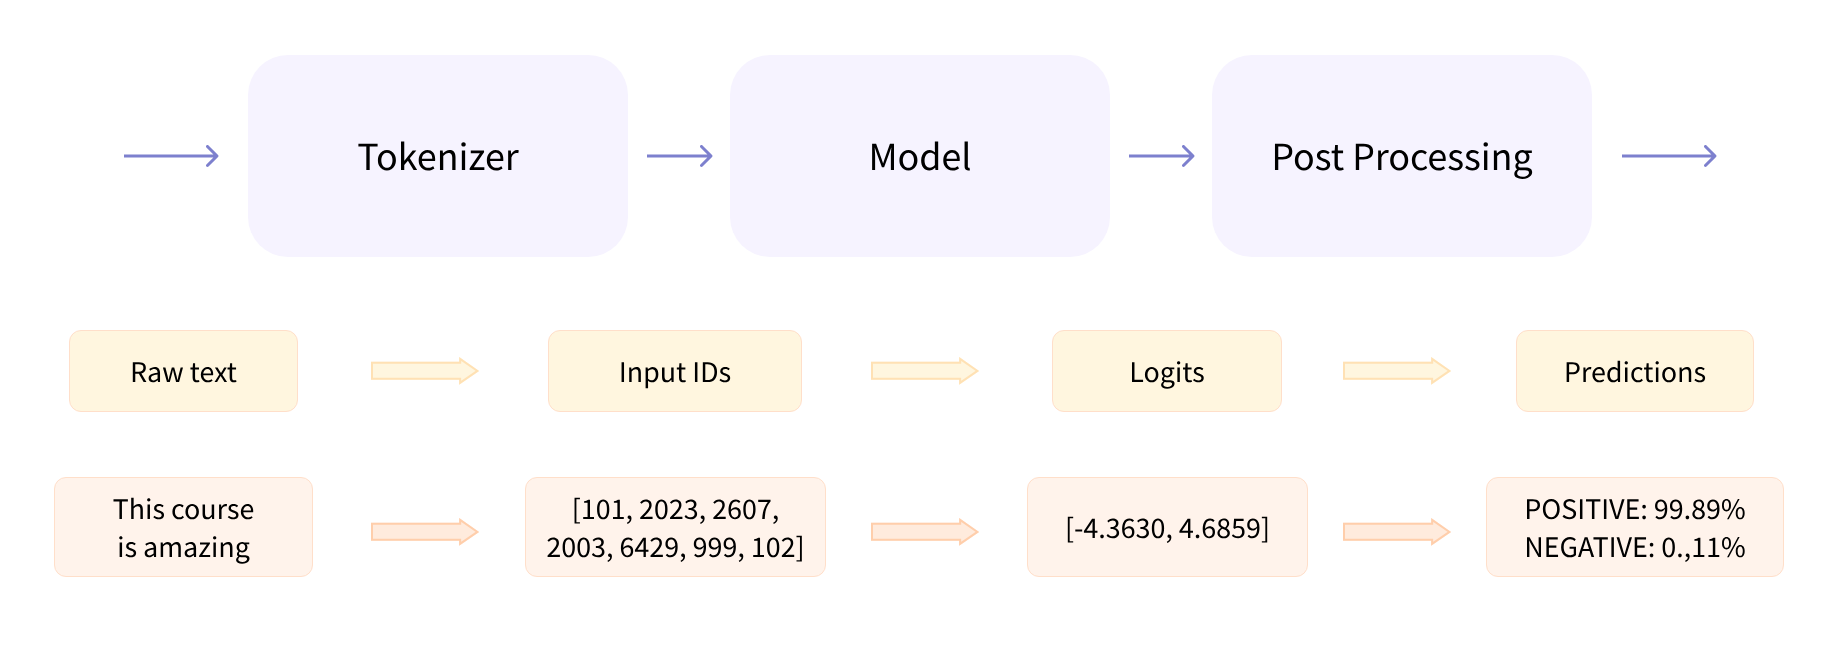

## **Sentiment Analysis**

In [ ]:
classifier = pipeline('sentiment-analysis')
classifier(['Tokenization is the process of breaking down raw text into smaller chunks called tokens.', 'Hugging Face is great!'])

In [ ]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

In [ ]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)
outputs = model(**inputs)

In [ ]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

Note that the outputs of 🤗 Transformers models behave like namedtuples or dictionaries. You can access the elements by attributes (like we did) or by key (outputs["last_hidden_state"]), or even by index if you know exactly where the thing you are looking for is (outputs[0]).

The vector output by the Transformer module is usually large. It generally has three dimensions:

- **Batch size:** The number of sequences processed at a time (2 in our example).
- **Sequence length:** The length of the numerical representation of the sequence (16 in our example).
- **Hidden size:** The vector dimension of each model input.
It is said to be “high dimensional” because of the last value. The hidden size can be very large (768 is common for smaller models, and in larger models this can reach 3072 or more).

**Model heads:**

Making sense out of numbers
The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:


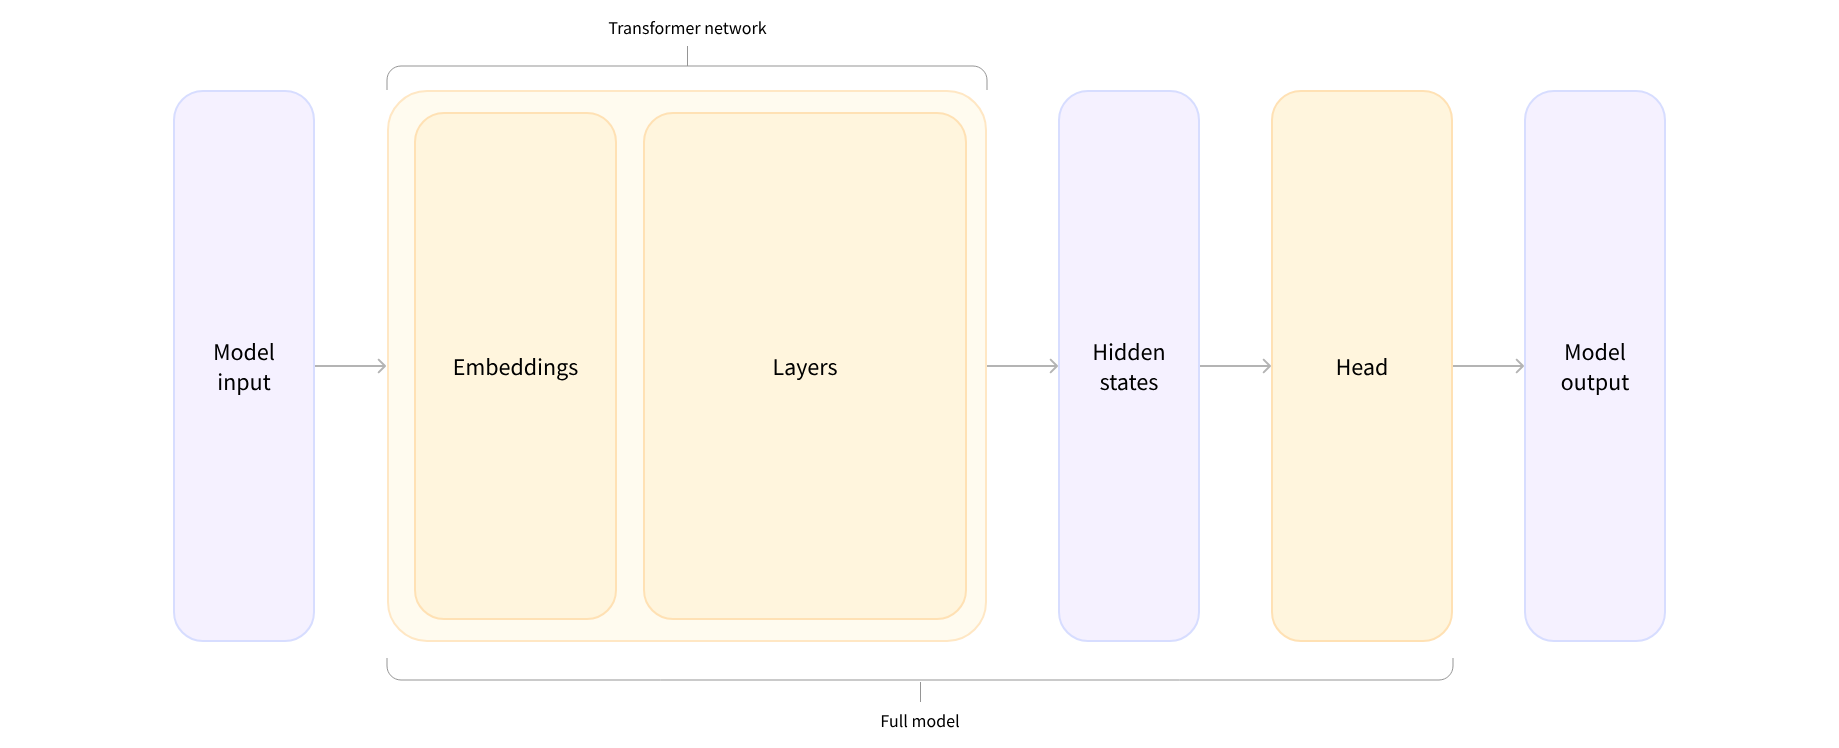

The output of the Transformer model is sent directly to the model head to be processed.

In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

- **Model (retrieve the hidden states)**
- **ForCausalLM**
- **ForMaskedLM**
- **ForMultipleChoice**
- **ForQuestionAnswering**
- **ForSequenceClassification**
- **ForTokenClassification**
- **and others** 🤗

For our example, we will need a model with a **sequence classification head** (to be able to classify the sentences as positive or negative). So, we won’t actually use the AutoModel class, but **AutoModelForSequenceClassification**:

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

Now if we look at the shape of our outputs, the dimensionality will be much lower: the model head takes as input the high-dimensional vectors we saw before, and outputs vectors containing two values (one per label):

In [ ]:
print(outputs.logits.shape)

Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.

**Postprocessing the output**

The values we get as output from our model don’t necessarily make sense by themselves. Let’s take a look:

In [ ]:
print(outputs.logits)

Our model predicted [-1.5607, 1.6123] for the first sentence and [ 4.1692, -3.3464] for the second one. Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

Now we can see that the model predicted [0.0402, 0.9598] for the first sentence and [0.9995, 0.0005] for the second one. These are recognizable probability scores.

To get the labels corresponding to each position, we can inspect the id2label attribute of the model config (more on this in the next section):

In [ ]:
model.config.id2label

Now we can conclude that the model predicted the following:

**First sentence:** NEGATIVE: 0.0402, POSITIVE: 0.9598

**Second sentence:** NEGATIVE: 0.9995, POSITIVE: 0.0005

We have successfully reproduced the three steps of the pipeline: preprocessing with tokenizers, passing the inputs through the model, and postprocessing! Now let’s take some time to dive deeper into each of those steps.

## **ChatBots**

In [ ]:
chatbot = pipeline("text2text-generation", model="facebook/blenderbot-400M-distill")
chatbot

In [ ]:
# Change the input format to a simple string
message = "How I can learn Python?"

# Pass the string directly to the pipeline
chatbot(message)

In [ ]:
# Change the input format to a simple string
message = "What else you will recommend?"

# Pass the string directly to the pipeline
chatbot(message)

The chatbot doesnot remember earlier conversation because it doesn't have any memory but still we can continue to chat in other way:

To include prior conversations in the LLM's context, you can add a 'message' to include the previous chat history.

## **Zero-shot Audio Classification**

In [ ]:
!pip install -U datasets

In [ ]:
dataset = load_dataset("ashraq/esc50")
dataset

In [ ]:
dataset['train']

In [ ]:
len(dataset['train'])

In [ ]:
dataset['train'][0]

In [ ]:
from IPython.display import Audio as IPythonAudio
# Access the first example (index 0) in the 'train' split
IPythonAudio(dataset['train'][0]["audio"]["array"],
             rate=dataset['train'][0]["audio"]["sampling_rate"])

In [ ]:
zero_shot_classifier = pipeline(
    task="zero-shot-audio-classification",
    model="laion/clap-htsat-unfused")

### **Sampling rate**

Sampling rate is absolutely crucial in zero-shot audio classification, just as it is in any audio processing task involving machine learning. Here's why and what it means in this context:

**What is Sampling Rate?**

Audio, in its natural form, is a continuous wave. To represent it digitally, we "sample" it, which means taking discrete measurements of the wave's amplitude at regular intervals. The **sampling rate** (measured in Hertz, Hz, or kilohertz, kHz) tells you how many of these samples are taken per second.

* **Higher sampling rate:** More samples per second, capturing more detail of the sound wave, resulting in higher fidelity (quality) audio.
* **Lower sampling rate:** Fewer samples per second, less detail, lower fidelity audio (e.g., telephone calls typically use 8kHz, while CD quality is 44.1kHz).

**Why is Sampling Rate Important in Zero-Shot Audio Classification?**

1.  **Model Compatibility:**
    * **Pre-trained models are trained on specific sampling rates.** A zero-shot audio classification model (like CLAP or a fine-tuned Whisper model) is pre-trained on vast amounts of audio data that has a consistent sampling rate (e.g., 16kHz, 44.1kHz, 48kHz).
    * **Mismatch causes problems:** If you feed an audio clip to the model that has a different sampling rate than what it was trained on, the model will misinterpret the audio. For example, a 5-second audio clip at 8kHz has 40,000 samples, but the *same 5-second clip* at 16kHz has 80,000 samples. If a model expects 16kHz and gets 8kHz audio, it might interpret it as being much shorter than it actually is, leading to incorrect classifications.

2.  **Feature Extraction:**
    * Before an audio model processes raw audio, it often converts it into features like spectrograms or embeddings. The sampling rate directly impacts how these features are generated. Inconsistent sampling rates will lead to inconsistent features, making it hard for the model to generalize.

3.  **Cross-Modal Alignment (for models like CLAP):**
    * Zero-shot audio classification often relies on **cross-modal models** (like CLAP) that learn to align audio embeddings with text embeddings. The quality and characteristics of the audio embeddings are directly influenced by the sampling rate. If the audio is downsampled too much, critical acoustic information needed to match it semantically with a text label might be lost.

**Practical Implication:**

When performing zero-shot audio classification, you **must ensure that the sampling rate of your input audio matches the sampling rate expected by the pre-trained model** you are using. If they differ, you'll need to **resample** your audio to match the model's required sampling rate. Libraries like `librosa` or functionalities within `datasets` can easily perform this resampling.

In [ ]:
zero_shot_classifier.feature_extractor.sampling_rate

In [ ]:
dataset['train'][0]["audio"]["sampling_rate"]

In [ ]:
from datasets import Audio

We are resampling because CLAP model expect sampling_rate = 48000 while dataset audios sampling_rate are 44100

In [ ]:
dataset = dataset.cast_column(
    "audio",
     Audio(sampling_rate=48_000))

In [ ]:
audio_sample = dataset['train'][0]
audio_sample

In [ ]:
candidate_labels = ["Sound of a dog",
                    "Sound of a Cat",
                    "Sound of a train"]

In [ ]:
zero_shot_classifier(audio_sample["audio"]["array"],
                     candidate_labels=candidate_labels)

## **Automatic speech recognition**

In [ ]:
dataset = load_dataset('openslr/librispeech_asr',
                    streaming=True,
                    trust_remote_code=True)

In [ ]:
dataset

In [ ]:
len(dataset)

In [ ]:
example = next(iter(dataset))
example

In [ ]:
# Assuming your IterableDatasetDict object is named 'dataset_dict'
# (Replace 'dataset_dict' with whatever variable holds your output)

# 1. Access the specific split
train_clean_100_split = dataset['train.clean.100']
print(train_clean_100_split)

# 2. Check inside (get the first example from this iterable split)
# Since it's an IterableDataset, you need to use iter() and next()
first_example = next(iter(train_clean_100_split))
print(first_example)

In [ ]:
# Assuming your IterableDatasetDict object is named 'dataset_dict'
# And you want to access the 'train.clean.100' split
train_clean_100_split = dataset['train.clean.100']

# Create an iterator for the split
data_iterator = iter(train_clean_100_split)

five_examples = []
for _ in range(5): # Loop 5 times
    try:
        five_examples.append(next(data_iterator))
    except StopIteration:
        # This handles cases where the dataset might have fewer than 5 examples
        print("Dataset has fewer than 5 examples.")
        break

# Now you can print or work with your 5 examples
for i, example in enumerate(five_examples):
    print(f"Example {i+1}:")
    print(example)
    print("-" * 30)

In [ ]:
list(five_examples[1])

In [ ]:
list(five_examples)[0]

In [ ]:
from IPython.display import Audio as IPythonAudio

IPythonAudio(example["audio"]["array"],
             rate=example["audio"]["sampling_rate"])

In [ ]:
from IPython.display import Audio as IPythonAudio, HTML, display
import base64
import io
import numpy as np
import os # Import os for os.path.basename and os.path.splitext

# --- 1. Ensure 'example' is available for demonstration ---
if 'example' not in locals():
    dummy_audio_array = np.random.uniform(-0.5, 0.5, 44100 * 3).astype(np.float32)
    example = {
        "audio": {
            "array": dummy_audio_array,
            "sampling_rate": 44100,
            "file": "dummy_audio.wav" # Added for dynamic filename testing
        }
    }
    print("NOTE: Using a dummy audio example for demonstration purposes.")
    print("In your actual notebook, 'example' should come from your dataset.")
    print("-" * 50)


# --- 2. Display Audio in Notebook with controlled width ---
# We'll use HTML to wrap the audio tag and potentially control its width.
# IPython.display.Audio itself doesn't offer direct width control in its constructor,
# but the underlying HTML <audio> tag can be styled.
# However, the simple 'display(IPythonAudio(...))' often uses default browser rendering.
# The best way to limit the width if it's overflowing is usually to wrap it
# or ensure the container allows wrapping.
# For direct audio player display, it's often browser-controlled.
# Let's try to ensure the *text* around it is not too wide if that's the issue.

print("Playing audio in the notebook:")
# The core audio player usually adapts. The "Playing aud" text might be a display issue.
# The most common approach is just to let it render, and rely on the notebook's scroll.
# If you want to force a smaller display, you might need a more complex HTML wrapper
# but for the default IPythonAudio, it's usually browser-managed.
display(IPythonAudio(example["audio"]["array"],
                     rate=example["audio"]["sampling_rate"]))


# --- 3. Provide Download Option (from previous robust code) ---
print("\n--- Attempting to generate Download Option ---")
try:
    import scipy.io.wavfile
    wav_io = io.BytesIO()
    scipy.io.wavfile.write(wav_io, example["audio"]["sampling_rate"], example["audio"]["array"])
    wav_io.seek(0)
    audio_base64 = base64.b64encode(wav_io.read()).decode('utf-8')

    audio_filename = "downloaded_audio.wav"
    if 'file' in example and example['file']:
        base_name = os.path.basename(example['file'])
        if '.' in base_name:
            audio_filename = os.path.splitext(base_name)[0] + ".wav"
        else:
            audio_filename = base_name + ".wav"
    elif 'id' in example:
        audio_filename = f"{example['id']}.wav"

    download_html = f'<a href="data:audio/wav;base64,{audio_base64}" download="{audio_filename}" style="display: inline-block; padding: 10px 20px; background-color: #007bff; color: white; text-decoration: none; border-radius: 5px; font-family: sans-serif;">Download Audio ({audio_filename})</a>'

    display(HTML(download_html))
    print("\nIf you don't see the link, check the output cell for errors above.")

except ImportError:
    print("\nError: 'scipy' library not found. Please install it using: pip install scipy")
except Exception as e:
    print(f"\nAn error occurred while generating the download link: {e}")
    print("Please ensure your 'example[\"audio\"][\"array\"]' is a numpy array and 'scipy' is installed.")

## **Building Pipeline**

In [ ]:
asr = pipeline(task="automatic-speech-recognition",
               model="distil-whisper/distil-small.en")

In [ ]:
asr.feature_extractor.sampling_rate

In [ ]:
example['audio']['sampling_rate']

In [ ]:
example['text']

In [ ]:
asr(example["audio"]["array"])

## **Building an app with Gradio**

In [ ]:
import gradio as gr
import requests

In [ ]:
app = gr.Blocks()

In [ ]:
app

### **Funtion to transcribe audio**

In [ ]:
import soundfile as sf

In [ ]:
def transcribe_speech(audio_filepath):
    if audio_filepath is None:
      gr.Warning('No audio found. Please try again!')
    # This line defines a Python function named 'transcribe_speech'
    # It takes one argument: 'audio_filepath', which is expected to be a string
    # representing the path to an audio file on your system (e.g., 'my_audio.wav').

    # 1. Load audio from file
    # This line uses 'sf.read()' (likely from the 'soundfile' library, or similar)
    # to read the contents of the audio file specified by 'audio_filepath'.
    # It returns two main pieces of information:
    # - 'audio': A NumPy array containing the numerical samples of the audio waveform.
    #            This is the raw digital representation of the sound.
    # - 'sr': The sampling rate (in Hertz) of the audio. This tells you how many
    #         samples per second are in the 'audio' array (e.g., 16000 Hz, 44100 Hz).
    audio, sr = sf.read(audio_filepath)

    # 2. Pass audio data to the ASR model/pipeline for transcription
    # This is the core step where the speech recognition happens.
    # - 'asr': This variable (which must be defined and initialized elsewhere in your code)
    #          represents your pre-trained ASR model or, more likely, a Hugging Face
    #          ASR pipeline (like the one you'd get from `pipeline("automatic-speech-recognition", model="...")`).
    # - `{"array": audio, "sampling_rate": sr}`: This is the crucial input format
    #          expected by many Hugging Face ASR models and pipelines. It's a dictionary
    #          where:
    #          - 'array': Contains the raw numerical audio waveform.
    #          - 'sampling_rate': Provides the corresponding sampling rate.
    #          The ASR model needs both to correctly interpret the audio.
    # - 'result': The output from the 'asr' model/pipeline. For ASR tasks, this is
    #             typically a dictionary containing the transcribed text and potentially
    #             other metadata (like word timestamps or confidence scores).
    result = asr(
        {"array": audio, "sampling_rate": sr}
    )

    # 3. Extract and return the transcribed text
    # The ASR pipeline or model usually returns its primary output (the transcription)
    # under a specific key, commonly 'text'.
    # This line extracts that text string from the 'result' dictionary.
    return result['text']

In [ ]:
transcribe_speech('/content/374-180298-0004.wav')

### **Ability to transcribe through mic**

In [ ]:
mic_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(
        sources="microphone",
        type="filepath",
        label="🎤 Speak into your microphone" # Appealing label
    ),
    outputs=gr.Textbox(
        label="📝 Transcription Result", # Appealing label
        lines=4, # Slightly more lines for longer transcriptions
        placeholder="Your transcribed text will appear here..."
    ),
    allow_flagging="never", # Disable flagging
    description="Record your voice directly using your device's microphone. Get an instant transcription."
)

### **Ability to transcribe through uploading audio**

In [ ]:
file_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(
        sources="upload", # Allow input from file upload
        type="filepath",  # Function receives audio as a temporary file path
        label="📁 Upload an Audio File" # Appealing label
    ),
    outputs=gr.Textbox(
        label="📝 Transcription Result", # Appealing label
        lines=4, # Slightly more lines
        placeholder="Upload an audio file (e.g., .wav, .mp3) to get its transcription."
    ),
    allow_flagging="never", # Disable flagging
    description="Upload an audio file for transcription."
)

### **Gradio Interface**

In [ ]:
custom_css = """
/* Import Google Font - Arial (or a very similar sans-serif if Arial isn't universally available on all systems) */
/* Note: Arial is typically a system font, so direct import isn't strictly necessary for it to work,
   but it's good practice for other fonts. */
@import url('https://fonts.googleapis.com/css2?family=Arial:wght@400;700&display=swap');

/* Apply Arial to ALL text elements by default within the Gradio container */
.gradio-container, body, button, input, select, textarea, div, p, span, h1, h2, h3, h4, h5, h6 {
    font-family: 'Arial', sans-serif !important;
}

/* Overall container styling */
.gradio-container {
    max-width: 900px; /* Limit overall width for better readability */
    margin: 30px auto; /* Center the app on the page */
    padding: 30px;
    border-radius: 15px; /* Rounded corners for a softer look */
    box-shadow: 0 8px 25px rgba(0, 0, 0, 0.1); /* Subtle shadow for depth */
    background-color: #ffffff; /* White background for the main content area */
}

/* Titles and Headers */
h1 {
    color: #34495e; /* Darker blue-grey for main title */
    text-align: center;
    font-size: 2.5em; /* Larger main title */
    margin-bottom: 10px;
    font-weight: 700; /* Bold */
}

h3 {
    color: #5d6d7e; /* Slightly lighter blue-grey for subtitle */
    text-align: center;
    font-size: 1.2em;
    margin-top: 0;
    margin-bottom: 25px;
}

p {
    text-align: center;
    color: #7f8c8d; /* Muted grey for descriptions */
    font-size: 0.95em;
    margin-bottom: 20px;
}

/* Tabbed Interface Styling */
.tabs {
    border-radius: 10px;
    overflow: hidden; /* Ensures rounded corners on tabs */
    margin-bottom: 20px;
}

.tab-nav button {
    background-color: #ecf0f1; /* Light grey for inactive tabs */
    color: #34495e; /* Dark text for inactive tabs */
    font-weight: bold;
    padding: 12px 20px;
    border-radius: 8px 8px 0 0;
    margin-right: 5px; /* Small space between tabs */
    transition: all 0.3s ease;
}

.tab-nav button.selected {
    background-color: #4a90e2; /* Vibrant blue for active tab */
    color: white; /* White text for active tab */
    box-shadow: 0 4px 10px rgba(74, 144, 226, 0.3); /* Subtle shadow for active tab */
}

/* Input and Output Component Styling (General) */
.gr-box {
    border-radius: 10px; /* Rounded corners for input/output boxes */
    border: 1px solid #dfe6e9; /* Light border */
    box-shadow: 0 2px 8px rgba(0, 0, 0, 0.05); /* Very subtle shadow */
    padding: 20px;
    background-color: #fcfcfc; /* Slightly off-white background */
}

/* Labels within components (e.g., "Upload Audio File", "Transcription Result") */
.label {
    font-weight: bold;
    color: #2c3e50; /* Dark text for labels */
    font-size: 1.1em;
    margin-bottom: 8px;
}

/* Buttons (Clear, Submit) */
.gr-button {
    background-color: #4a90e2 !important; /* Primary blue for actions */
    color: white !important;
    border: none !important;
    border-radius: 8px !important; /* Rounded buttons */
    padding: 12px 25px !important;
    font-weight: bold !important;
    transition: background-color 0.3s ease, box-shadow 0.3s ease !important;
    margin: 5px; /* Spacing between buttons */
}

.gr-button:hover {
    background-color: #3a7bd2 !important; /* Darker blue on hover */
    box-shadow: 0 4px 15px rgba(74, 144, 226, 0.4) !important;
}

/* Clear button specific */
.gr-button.secondary {
    background-color: #e0e6eb !important; /* Lighter grey for clear */
    color: #34495e !important;
}
.gr-button.secondary:hover {
    background-color: #d1d8df !important;
    box-shadow: none !important;
}

/* Textbox specific */
textarea {
    border-radius: 8px !important;
    border: 1px solid #bdc3c7 !important;
    padding: 10px !important;
    resize: vertical; /* Allow vertical resizing */
}

/* Audio component player */
.gr-audio-player {
    border-radius: 8px;
    background-color: #f0f0f0;
    padding: 10px;
}

/* Footer styling */
hr {
    border: none;
    border-top: 1px solid #e0e0e0;
    margin-top: 30px;
    margin-bottom: 15px;
}

.footer-text {
    font-size: 0.85em;
    color: #a0a0a0;
    text-align: center;
}
"""

# --- 6. Main Gradio App using Blocks for layout and styling ---
# Initialize a Gradio Blocks interface with a theme and custom CSS.
demo = gr.Blocks(
    theme=gr.themes.Soft(), # A good base theme for soft colors
    css=custom_css          # Apply our custom CSS
)

# Define the layout within the 'demo' Blocks context
with demo:
    # Main Title and Description using Markdown for rich formatting and appealing colors
    # Removed inline style for font-family as it's handled by global CSS now.
    gr.Markdown(
        """
        <center>
            <h1 style="color: #4A90E2;">
                🎙️ AI-Powered Speech-to-Text Transcriber 📝
            </h1>
            <h3 style="color: #6C7A89;">
                Developed by Muhammad Farhan Aslam.
            </h3>
            <h3 style="color: #6C7A89;">
                Convert spoken words into accurate text with ease and precision.
            </h3>
            <p style="color: #8C9CA7; font-size: 1.05em;">
                Effortlessly transcribe audio from your microphone or by uploading a file.
                This application leverages advanced AI to provide clear and reliable transcriptions.
            </p>
        </center>
        """
    )

    # Create a tabbed interface for microphone and file upload transcription
    gr.TabbedInterface(
        [file_transcribe, mic_transcribe],
        ["📁 Transcribe Audio File", "🎤 Transcribe from Microphone"],
    )

    # Add a subtle footer for information or credits
    gr.Markdown(
        """
        <hr>
        <p class="footer-text">
            Built with ❤️ and Gradio on Hugging Face Transformers.
        </p>
        """
    )
start_port = int(os.environ.get('PORT1', 7861))
demo.launch(share=True, server_port=start_port)

# **Upload app to Huggingface spaces**

In [ ]:
!mkdir app

In [ ]:
%cd /content/app

In [ ]:
%%writefile requirements.txt

# requirements.txt

gradio
transformers
soundfile
torch

In [ ]:
%%writefile app.py

# app.py

import gradio as gr
import soundfile as sf
import os
from transformers import pipeline

asr = pipeline(task="automatic-speech-recognition",
               model="distil-whisper/distil-small.en")

def transcribe_speech(audio_filepath):
    if audio_filepath is None:
      gr.Warning('No audio found. Please try again!')
    # This line defines a Python function named 'transcribe_speech'
    # It takes one argument: 'audio_filepath', which is expected to be a string
    # representing the path to an audio file on your system (e.g., 'my_audio.wav').

    # 1. Load audio from file
    # This line uses 'sf.read()' (likely from the 'soundfile' library, or similar)
    # to read the contents of the audio file specified by 'audio_filepath'.
    # It returns two main pieces of information:
    # - 'audio': A NumPy array containing the numerical samples of the audio waveform.
    #            This is the raw digital representation of the sound.
    # - 'sr': The sampling rate (in Hertz) of the audio. This tells you how many
    #         samples per second are in the 'audio' array (e.g., 16000 Hz, 44100 Hz).
    audio, sr = sf.read(audio_filepath)

    # 2. Pass audio data to the ASR model/pipeline for transcription
    # This is the core step where the speech recognition happens.
    # - 'asr': This variable (which must be defined and initialized elsewhere in your code)
    #          represents your pre-trained ASR model or, more likely, a Hugging Face
    #          ASR pipeline (like the one you'd get from `pipeline("automatic-speech-recognition", model="...")`).
    # - `{"array": audio, "sampling_rate": sr}`: This is the crucial input format
    #          expected by many Hugging Face ASR models and pipelines. It's a dictionary
    #          where:
    #          - 'array': Contains the raw numerical audio waveform.
    #          - 'sampling_rate': Provides the corresponding sampling rate.
    #          The ASR model needs both to correctly interpret the audio.
    # - 'result': The output from the 'asr' model/pipeline. For ASR tasks, this is
    #             typically a dictionary containing the transcribed text and potentially
    #             other metadata (like word timestamps or confidence scores).
    result = asr(
        {"array": audio, "sampling_rate": sr}
    )

    # 3. Extract and return the transcribed text
    # The ASR pipeline or model usually returns its primary output (the transcription)
    # under a specific key, commonly 'text'.
    # This line extracts that text string from the 'result' dictionary.
    return result['text']


mic_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(
        sources="microphone",
        type="filepath",
        label="🎤 Speak into your microphone" # Appealing label
    ),
    outputs=gr.Textbox(
        label="📝 Transcription Result", # Appealing label
        lines=4, # Slightly more lines for longer transcriptions
        placeholder="Your transcribed text will appear here..."
    ),
    flagging_mode="never", # Disable flagging
    description="Record your voice directly using your device's microphone. Get an instant transcription."
)


file_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(
        sources="upload", # Allow input from file upload
        type="filepath",  # Function receives audio as a temporary file path
        label="📁 Upload an Audio File" # Appealing label
    ),
    outputs=gr.Textbox(
        label="📝 Transcription Result", # Appealing label
        lines=4, # Slightly more lines
        placeholder="Upload an audio file (e.g., .wav, .mp3) to get its transcription."
    ),
    flagging_mode="never", # Disable flagging
    description="Upload an audio file for transcription."
)


custom_css = """
/* Import Google Font - Arial (or a very similar sans-serif if Arial isn't universally available on all systems) */
/* Note: Arial is typically a system font, so direct import isn't strictly necessary for it to work,
   but it's good practice for other fonts. */
@import url('https://fonts.googleapis.com/css2?family=Arial:wght@400;700&display=swap');

/* Apply Arial to ALL text elements by default within the Gradio container */
.gradio-container, body, button, input, select, textarea, div, p, span, h1, h2, h3, h4, h5, h6 {
    font-family: 'Arial', sans-serif !important;
}

/* Overall container styling */
.gradio-container {
    max-width: 900px; /* Limit overall width for better readability */
    margin: 30px auto; /* Center the app on the page */
    padding: 30px;
    border-radius: 15px; /* Rounded corners for a softer look */
    box-shadow: 0 8px 25px rgba(0, 0, 0, 0.1); /* Subtle shadow for depth */
    background-color: #ffffff; /* White background for the main content area */
}

/* Titles and Headers */
h1 {
    color: #34495e; /* Darker blue-grey for main title */
    text-align: center;
    font-size: 2.5em; /* Larger main title */
    margin-bottom: 10px;
    font-weight: 700; /* Bold */
}

h3 {
    color: #5d6d7e; /* Slightly lighter blue-grey for subtitle */
    text-align: center;
    font-size: 1.2em;
    margin-top: 0;
    margin-bottom: 25px;
}

p {
    text-align: center;
    color: #7f8c8d; /* Muted grey for descriptions */
    font-size: 0.95em;
    margin-bottom: 20px;
}

/* Tabbed Interface Styling */
.tabs {
    border-radius: 10px;
    overflow: hidden; /* Ensures rounded corners on tabs */
    margin-bottom: 20px;
}

.tab-nav button {
    background-color: #ecf0f1; /* Light grey for inactive tabs */
    color: #34495e; /* Dark text for inactive tabs */
    font-weight: bold;
    padding: 12px 20px;
    border-radius: 8px 8px 0 0;
    margin-right: 5px; /* Small space between tabs */
    transition: all 0.3s ease;
}

.tab-nav button.selected {
    background-color: #4a90e2; /* Vibrant blue for active tab */
    color: white; /* White text for active tab */
    box-shadow: 0 4px 10px rgba(74, 144, 226, 0.3); /* Subtle shadow for active tab */
}

/* Input and Output Component Styling (General) */
.gr-box {
    border-radius: 10px; /* Rounded corners for input/output boxes */
    border: 1px solid #dfe6e9; /* Light border */
    box-shadow: 0 2px 8px rgba(0, 0, 0, 0.05); /* Very subtle shadow */
    padding: 20px;
    background-color: #fcfcfc; /* Slightly off-white background */
}

/* Labels within components (e.g., "Upload Audio File", "Transcription Result") */
.label {
    font-weight: bold;
    color: #2c3e50; /* Dark text for labels */
    font-size: 1.1em;
    margin-bottom: 8px;
}

/* Buttons (Clear, Submit) */
.gr-button {
    background-color: #4a90e2 !important; /* Primary blue for actions */
    color: white !important;
    border: none !important;
    border-radius: 8px !important; /* Rounded buttons */
    padding: 12px 25px !important;
    font-weight: bold !important;
    transition: background-color 0.3s ease, box-shadow 0.3s ease !important;
    margin: 5px; /* Spacing between buttons */
}

.gr-button:hover {
    background-color: #3a7bd2 !important; /* Darker blue on hover */
    box-shadow: 0 4px 15px rgba(74, 144, 226, 0.4) !important;
}

/* Clear button specific */
.gr-button.secondary {
    background-color: #e0e6eb !important; /* Lighter grey for clear */
    color: #34495e !important;
}
.gr-button.secondary:hover {
    background-color: #d1d8df !important;
    box-shadow: none !important;
}

/* Textbox specific */
textarea {
    border-radius: 8px !important;
    border: 1px solid #bdc3c7 !important;
    padding: 10px !important;
    resize: vertical; /* Allow vertical resizing */
}

/* Audio component player */
.gr-audio-player {
    border-radius: 8px;
    background-color: #f0f0f0;
    padding: 10px;
}

/* Footer styling */
hr {
    border: none;
    border-top: 1px solid #e0e0e0;
    margin-top: 30px;
    margin-bottom: 15px;
}

.footer-text {
    font-size: 0.85em;
    color: #a0a0a0;
    text-align: center;
}
"""

# --- 6. Main Gradio App using Blocks for layout and styling ---
# Initialize a Gradio Blocks interface with a theme and custom CSS.
demo = gr.Blocks(
    theme=gr.themes.Soft(), # A good base theme for soft colors
    css=custom_css          # Apply our custom CSS
)

# Define the layout within the 'demo' Blocks context
with demo:
    # Main Title and Description using Markdown for rich formatting and appealing colors
    # Removed inline style for font-family as it's handled by global CSS now.
    gr.Markdown(
        """
        <center>
            <h1 style="color: #4A90E2;">
                🎙️ AI-Powered Speech-to-Text Transcriber 📝
            </h1>
            <h3 style="color: #6C7A89;">
                Developed by Muhammad Farhan Aslam.
            </h3>
            <h3 style="color: #6C7A89;">
                Convert spoken words into accurate text with ease and precision.
            </h3>
            <p style="color: #8C9CA7; font-size: 1.05em;">
                Effortlessly transcribe audio from your microphone or by uploading a file.
                This application leverages advanced AI to provide clear and reliable transcriptions.
            </p>
        </center>
        """
    )

    # Create a tabbed interface for microphone and file upload transcription
    gr.TabbedInterface(
        [file_transcribe, mic_transcribe],
        ["📁 Transcribe Audio File", "🎤 Transcribe from Microphone"],
    )

    # Add a subtle footer for information or credits
    gr.Markdown(
        """
        <hr>
        <p class="footer-text">
            Built with ❤️ and Gradio on Hugging Face Transformers.
        </p>
        """
    )
# start_port = int(os.environ.get('PORT1', 7861))
demo.launch(share=True)

In [ ]:
!gradio deploy